<a href="https://colab.research.google.com/github/Jahan08/Kinase-Data-analysis/blob/main/Kinase_similarity_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T024 · Kinase similarity: Sequence

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

In this talktorial, we investigate sequence similarity for kinases of interest. KLIFS API is used to retrieve the $85$ residues of the pocket sequence for each kinase.

Two similarity measures are implemented:

   1. Sequence identity, i.e., the similarity which is based on character-wise discrepancy.
   2. Sequence similarity, i.e., the similarity which is based on a substitution matrix, thus, reflecting similarities between amino acids.
   
_Note_: We focus on similarities between orthosteric kinase binding sites; similarities to allosteric binding sites are not covered.

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor: Sequence
    * Identity score
    * Substitution score
* From similarity matrix to distance matrix

### Contents in *Practical*

* Define the kinases of interest
* Retrieve sequences from KLIFS
* Sequence similarity
    * Identity score
    * Substitution score
* Kinase similarity
  * Visualize similarity as kinase matrix
  * Save kinase similarity matrix
* Kinase distance matrix
  * Save kinase distance matrix

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629)
* KLIFS
  * KLIFS URL: https://klifs.net/
  * KLIFS database: [<i>Nucleic Acid Res.</i> (2020), <b>49(D1)</b>, D562-D569](https://doi.org/10.1093/nar/gkaa895)
* Sequence-based kinase clustering: Manning _et al._ [<i>Science</i> (2002), <b>298(5600)</b>, 1912-1934](https://doi.org/10.1126/science.1075762)
* Substitution matrix: [<i>PNAS</i> (1992), <b>89(22)<b>, 10915-10919](https://doi.org/10.1073/pnas.89.22.10915)
* Biotite
    * Documentation: https://www.biotite-python.org/index.html
    * [Blosum matrix](https://www.biotite-python.org/examples/gallery/sequence/blosum_dendrogram.html?highlight=blosum)
* Sequence logo: http://www.cbs.dtu.dk/biotools/Seq2Logo/    

## Theory

### Kinase dataset

We use the kinase selection as defined in __Talktorial T023__.

### Kinase similarity descriptor: Sequence

As mentioned in the previous talktorial, sequence is often used to assess kinase similarity (see the phylogenetic tree developed by Manning _et al._ [<i>Science</i> (2002), <b>298(5600)</b>, 1912-1934](https://doi.org/10.1126/science.1075762)).

In this talktorial, the KLIFS pocket sequence is used for two main reasons:

1. The sequence is of fixed length (it contains $85$ residues), which makes computation for pairwise similarity between two sequences straightforward.

2. The binding pocket is where the action takes place. Why consider the full kinase sequence when an $85$ residues sequence contains most relevant information?

![sequence_logo](images/sequence_logo.png)

_Figure 1:_
The sequence logo shows amino acid binding motifs and sequence profiles such as amino acid depletion. For example, the sequence logo easily visualizes the conserved G-rich loop (position 4-9) and the DFG motif (position 81-83), see __Talktorial T023__ for more details.

**Note for reproducibility:**
The figure is generated using the Seq2Logo tool available at http://www.cbs.dtu.dk/biotools/Seq2Logo/. The input is the $85$ residues KLIFS binding pocket for the query kinases. All parameters are the the default ones. For the graphical layout, the entry _Stacks Per Line_ is set to $85$ and _Page size_ to $1200 \times 480.$

We now describe two ways to compare pocket sequences.

#### Identity score
A simple way of assessing the similarity between two sequences is to use the so-called identity score.
First, a match vector is created: it checks whether for each position the characters from the two sequences are identical. If they are, the entry is set to $1,$ and $0$ otherwise.

The identity score is computed by summing the elements in the match vector and normalizing the entry by the length of the sequence, which is $85$ in the case of KLIFS pocket sequence.

Let's consider the identity matrix $I$ below:

|       | A     | C     | D     | E     | ... |
|-------|-------|-----  |-----  |-----  |-----|
| **A** | **1** | 0     | 0     | 0     | ... |
| **C** | 0     | **1** | 0     | 0     | ... |
| **D** | 0     | 0     | **1** | 0     | ... |
| **E** | 0     | 0     | 0     | **1** | ... |
| ...   | ...   | ...   | ...   | ...   | ... |


and let $M = len(K_i) = len(K_j)$ for two kinases $K_i$ and $K_j$.

We use the following as similarity between kinases $K_i$ and $K_j$:

$$
\text{similarity}(K_i, K_j) = \frac{1}{M} \sum_{n=1}^{M} I (K_i[n], K_j[n]),
$$

where $K_i[n]$ represents the amino acid at position $n$ of the sequence of kinase $i$.

#### Substitution score
Although the identity score is an easy measure of similarity, it does not take into account the rate at which an amino acid may change into another and treats all residues uniformly.

The substitution score takes the changes of the amino acids over evolutionary time into account. It makes use of a substitution matrix, where each entry gives a score between two amino acids.
In this talktorial, we use the BLOSUM substitution matrix [<i>PNAS</i> (1992), <b>89(22)<b>, 10915-10919](https://doi.org/10.1073/pnas.89.22.10915), implemented in `biotite`.

The BLOSUM substitution matrix $SM$ is defined as below (the full matrix will be displayed in the _Practical_ part):

|       | A     | C     | D     | E     | ... |
|-------|-------|-----  |-----  |-----  |-----|
| **A** | 4     | 0     | -2    | -1    | ... |
| **C** | 0     | 9     | -3    | -4    | ... |
| **D** | -2    | -3    | 6     | 2     | ... |
| **E** | -1    | -4    | 2     | 5     | ... |
| ...   | ...   | ...   | ...   | ...   | ... |

The BLOSUM substitution matrix is symmetric, as shown in the practical part.

For convenience, we will translate and rescale the matrix using the following:

$$
SM' = SM - min(SM),
$$

for translation, and

for all $x, y$

$$
SM''(x, y) = \frac{SM'[x,y]}{\sqrt{SM'[x,x]*SM'[y,y]}},
$$

for rescaling, such that

$$
SM''[x, x] = 1 \text{ for all } x,
$$ and

$$
SM''[x, y] \in [0, 1] \text{ for all } x,y.
$$

We use the following as similarity between kinases $K_i$ and $K_j$:

$$
\text{similarity}(K_i, K_j) = \frac{1}{M} \sum_{n=1}^{M} SM''\big(K_i[n], K_j[n]\big),
$$

where $K_i[n]$ represents the amino acid at position $n$ of the sequence of kinase $i$ and $M = len(K_i) = len(K_j)$.

### From similarity matrix to distance matrix

In order to apply some clustering algorithm to assess the similarity between kinases, it is necessary to start with a distance matrix. A similarity matrix is not, by definition, a distance matrix. For example, the diagonal elements are not zero. For now, we map the similarity matrix $SM$ to a distance matrix $DM$ using

$$ DM = 1-SM.$$

See __Talktorial T028__ for more details.

## Practical

In [1]:
!pip install -q biotite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 29.7 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import requests

import pandas as pd
import numpy as np
import seaborn as sns
import biotite.sequence.align as align

In [3]:
configs = pd.read_csv("/content/pipeline_configs.csv")
configs = configs.set_index("variable")["default_value"]
DEMO = bool(int(configs["DEMO"]))
print(f"Run in demo mode: {DEMO}")
# NBVAL_CHECK_OUTPUT

Run in demo mode: True


### Define the kinases of interest

Let's load the kinase selection as defined in __Talktorial T023__.

In [38]:
kinase_selection_df = pd.read_csv("/content/klifs.csv")
kinase_selection_df
# NBVAL_CHECK_OUTPUT

,kinase_klifs,kinase,group,full_kinase_name,uniprot_id
0,CDC2,CDK1,CMGC,cyclin-dependent kinase 1,P06493
1,CDC7,CDC7,Other,cell division cycle 7,O00311
2,CDK10,CDK10,CMGC,cyclin-dependent kinase 10,Q15131
3,CDK11,CDK19,CMGC,cyclin-dependent kinase 19,Q9BWU1
4,CDK2,CDK2,CMGC,cyclin-dependent kinase 2,P24941
5,CDK3,CDK3,CMGC,cyclin-dependent kinase 3,Q00526
6,CDK4,CDK4,CMGC,cyclin-dependent kinase 4,P11802
7,CDK5,CDK5,CMGC,cyclin-dependent kinase 5,Q00535
8,CDK6,CDK6,CMGC,cyclin-dependent kinase 6,Q00534
9,CDK7,CDK7,CMGC,cyclin-dependent kinase 7,P50613


### Retrieve sequences from KLIFS

We use the KLIFS API to retrieve the $85$-long pocket sequence for each kinase.

In [39]:
def klifs_pocket_sequence(klifs_kinase_name):
    """
    Retrieves the pocket sequence from KLIFS using the API.

    Parameters
    ----------
    klifs_kinase_name : str
        The KLIFS name of the kinase of interest.

    Returns
    -------
    str :
        The 85 residues pocket sequence from KLIFS,
        if the kinase name is valid, None otherwise.
    """
    response = requests.get(
        f"https://klifs.net/api/kinase_ID?kinase_name={klifs_kinase_name}&species=HUMAN"
    )

    if response.status_code == 200:
        return response.json()[0]["pocket"]
    else:
        print(f"KLIFS failed for kinase {klifs_kinase_name}")
        return None

We create a dictionary made of the kinase name and its associated pocket sequence. This dictionary is used throughout this notebook.

In [40]:
kinase_sequences_dict = {}
for kinase in kinase_selection_df["kinase_klifs"]:
    kinase_sequences_dict[kinase] = klifs_pocket_sequence(kinase)

for name, sequence in kinase_sequences_dict.items():
    print(f"{name:10}{sequence}")
# NBVAL_CHECK_OUTPUT

CDC2      EKIGEGTYGVVYKVAMKKITAIREISLLKELRPNIVSLQDVYLIFEFLS-MDLKKYLDSFCHSRRVLHRDLKPQNLLILADFGLA
CDC7      DKIGEGTFSSVYLIALKHLRIAAELQCLTVAGDNVMGVKYCVIAMPYLE-HESFLD--IRIHQFGIVHRDVKPSNFLYLVDFGLA
CDK10     NRIGEGTYGIVYRVALKKVSSLREITLLLRLRPNIVELKEVFLVMGYCE-QDLASLLENYLHRNFIIHRDLKVSNLLMTADFGLA
CDK11     CKVGRGTYGHVYKYALKQISACREIALLRELKPNVIALQKVWLLFDYAE-HDLWHIIKFYLHANWVLHRDLKPANILVIADMGFA
CDK2      EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFEFLH-QDLKKFMDAFCHSHRVLHRDLKPQNLLILADFGLA
CDK3      EKIGEGTYGVVYKVALKKITAIREISLLKELKPNIVRLLDVYLVFEFLS-QDLKKYMDSFCHSHRVIHRDLKPQNLLILADFGLA
CDK4      AEIGVGAYGTVYKVALKSVSTVREVALLRRLEPNVVRLMDVTLVFEHVD-QDLRTYLDKFLHANCIVHRDLKPENILVLADFGLA
CDK5      EKIGEGTYGTVFKVALKRVSALREICLLKELKKNIVRLHDVTLVFEFCD-QDLKKYFDSFCHSRNVLHRDLKPQNLLILADFGLA
CDK6      AEIGEGAYGKVFKVALKRVSTIREVAVLRHLEPNVVRLFDVTLVFEHVD-QDLTTYLDKFLHSHRVVHRDLKPQNILVLADFGLA
CDK7      DFLGEGQFATVYKVAIKKITALREIKLLQELSPNIIGLLDASLVFDFME-TDLEVIIKDYLHQHWILHRDLKPNNLLLLADFGLA
CDK8      CKVGRGTYGHVYKYALKQISACREIALLRE

As shown in the cell above, some sequences have missing residues, denoted by "-". Let's plot these sequences as heatmap for a quick visual on conserved regions.

<ipython-input-41-7ce28f15bccf>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  kinase_sequences_int_df = kinase_sequences_df.applymap(lambda x: letter_to_int[x])


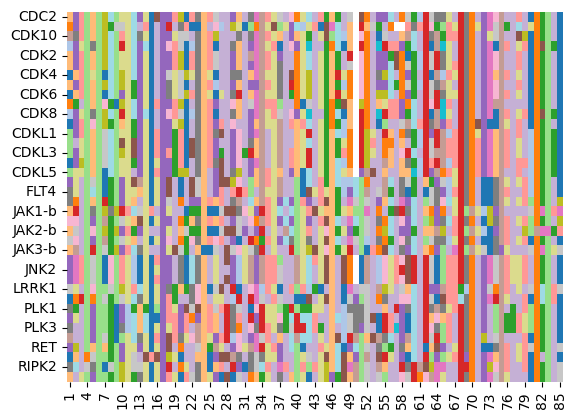

In [41]:
# Cast dict to DataFrame
kinase_sequences_df = pd.DataFrame(
    [list(i) for i in kinase_sequences_dict.values()],
    index=kinase_sequences_dict.keys(),
    columns=range(1, 86),
)
# Cast letters to integers (gap is set to None)
letter_to_int = {letter: ix for ix, letter in enumerate(list("ACDEFGHIKLMNPQRSTVWY"), 1)}
letter_to_int["-"] = None
kinase_sequences_int_df = kinase_sequences_df.applymap(lambda x: letter_to_int[x])
# Show heatmap (qualitative colormap)
ax = sns.heatmap(kinase_sequences_int_df, cmap="tab20", cbar=False)

### Sequence similarity

Given two kinases, we create functions which account for identity or substitution similarity, as described in the _Theory_ part.

#### Identity score
We first define a function which compares element-wise characters in two sequences.

In [42]:
def identity_score(sequence1, sequence2):
    """
    Computes the element-wise binary similarity between two sequences.

    Parameters
    ----------
    sequence1 : np.array
        An array of characters describing the first sequence.
    sequence2 : np.array
        An array of characters describing the second sequence.

    Returns
    -------
    np.array
        The bool array for each character.
        1 if the elements are identical,
        0 otherwise.
    """
    # True is the character is the same, False otherwise
    return np.compare_chararrays(sequence1, sequence2, cmp="==", rstrip=True)

#### Substitution score
We now define the function which is more specific to amino acids grouping and use the `biotite` library to retrieve the BLOSUM substitution matrix.

The substitution matrix can be retrieve from `biotite` using the following command:

In [43]:
substitution_matrix = align.SubstitutionMatrix.std_protein_matrix()
print(substitution_matrix)
# NBVAL_CHECK_OUTPUT

    A   C   D   E   F   G   H   I   K   L   M   N   P   Q   R   S   T   V   W   Y   B   Z   X   *
A   4   0  -2  -1  -2   0  -2  -1  -1  -1  -1  -2  -1  -1  -1   1   0   0  -3  -2  -2  -1   0  -4
C   0   9  -3  -4  -2  -3  -3  -1  -3  -1  -1  -3  -3  -3  -3  -1  -1  -1  -2  -2  -3  -3  -2  -4
D  -2  -3   6   2  -3  -1  -1  -3  -1  -4  -3   1  -1   0  -2   0  -1  -3  -4  -3   4   1  -1  -4
E  -1  -4   2   5  -3  -2   0  -3   1  -3  -2   0  -1   2   0   0  -1  -2  -3  -2   1   4  -1  -4
F  -2  -2  -3  -3   6  -3  -1   0  -3   0   0  -3  -4  -3  -3  -2  -2  -1   1   3  -3  -3  -1  -4
G   0  -3  -1  -2  -3   6  -2  -4  -2  -4  -3   0  -2  -2  -2   0  -2  -3  -2  -3  -1  -2  -1  -4
H  -2  -3  -1   0  -1  -2   8  -3  -1  -3  -2   1  -2   0   0  -1  -2  -3  -2   2   0   0  -1  -4
I  -1  -1  -3  -3   0  -4  -3   4  -3   2   1  -3  -3  -3  -3  -2  -1   3  -3  -1  -3  -3  -1  -4
K  -1  -3  -1   1  -3  -2  -1  -3   5  -2  -1   0  -1   1   2   0  -1  -2  -3  -2   0   1  -1  -4
L  -1  -1  -4  -3   

Check for symmetry:

In [44]:
substitution_matrix.is_symmetric()
# NBVAL_CHECK_OUTPUT

True

Let's perform the translation-rescaling step we discussed in the _Theory_ part.

In [45]:
def _translate_rescale_substitution_matrix(
    substitution_matrix=align.SubstitutionMatrix.std_protein_matrix(),
):
    """
    Translate and rescale substitution matrix.

    Parameters
    ----------
    substitution_matrix : biotite.sequence.align.SubstitutionMatrix
        A substitution matrix specific to amino acids.
        The default is align.SubstitutionMatrix.std_protein_matrix()
        from biotite, which represents BLOSUM62.

    Returns
    -------
    pd.DataFrame
        Translated and rescaled substitution matrix as DataFrame
        (index/columns contain letters).
    """
    # Retrieve np.array from substitution matrix
    score_matrix = substitution_matrix.score_matrix()

    # Translation of substitution matrix
    translated_matrix = score_matrix - np.min(score_matrix)

    # Rescaling
    normalized_score_matrix = np.zeros(score_matrix.shape)
    for i in range(score_matrix.shape[0]):
        for j in range(score_matrix.shape[0]):
            normalized_score_matrix[i, j] = translated_matrix[i, j] / np.sqrt(
                translated_matrix[i, i] * translated_matrix[j, j]
            )

    # Create DataFrame from matrix with letters as index/column names
    normalized_score_matrix = pd.DataFrame(
        normalized_score_matrix,
        columns=substitution_matrix.get_alphabet1(),
        index=substitution_matrix.get_alphabet1(),
    )

    # Check for symmetry
    symmetric = (
        normalized_score_matrix.values == normalized_score_matrix.values.transpose()
    ).all()
    if not symmetric:
        raise ValueError(f"Translated/rescaled matrix is not symmetric.")

    return normalized_score_matrix

Let's take a look at the translated and rescaled version of the substitution matrix.

In [46]:
_translate_rescale_substitution_matrix().style.format("{:.2f}")

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,B,Z,X,*
A,1.00,0.39,0.22,0.35,0.22,0.45,0.20,0.38,0.35,0.38,0.35,0.22,0.32,0.35,0.35,0.62,0.47,0.50,0.09,0.21,0.25,0.38,0.82,0.00
C,0.39,1.00,0.09,0.00,0.18,0.09,0.08,0.29,0.09,0.29,0.28,0.09,0.08,0.09,0.09,0.29,0.28,0.29,0.14,0.17,0.10,0.10,0.32,0.00
D,0.22,0.09,1.00,0.63,0.10,0.30,0.27,0.11,0.32,0.00,0.11,0.50,0.29,0.42,0.21,0.45,0.32,0.11,0.00,0.10,0.89,0.56,0.55,0.00
E,0.35,0.00,0.63,1.00,0.11,0.21,0.38,0.12,0.56,0.12,0.22,0.42,0.30,0.67,0.44,0.47,0.33,0.24,0.09,0.20,0.59,0.94,0.58,0.00
F,0.22,0.18,0.10,0.11,1.00,0.10,0.27,0.45,0.11,0.45,0.42,0.10,0.00,0.11,0.11,0.22,0.21,0.34,0.41,0.67,0.11,0.11,0.55,0.00
G,0.45,0.09,0.30,0.21,0.10,1.00,0.18,0.00,0.21,0.00,0.11,0.40,0.19,0.21,0.21,0.45,0.21,0.11,0.16,0.10,0.34,0.22,0.55,0.00
H,0.20,0.08,0.27,0.38,0.27,0.18,1.00,0.10,0.29,0.10,0.19,0.46,0.17,0.38,0.38,0.31,0.19,0.10,0.15,0.52,0.41,0.41,0.50,0.00
I,0.38,0.29,0.11,0.12,0.45,0.00,0.10,1.00,0.12,0.75,0.59,0.11,0.11,0.12,0.12,0.25,0.35,0.88,0.09,0.32,0.12,0.12,0.61,0.00
K,0.35,0.09,0.32,0.56,0.11,0.21,0.29,0.12,1.00,0.24,0.33,0.42,0.30,0.56,0.67,0.47,0.33,0.24,0.09,0.20,0.47,0.59,0.58,0.00
L,0.38,0.29,0.00,0.12,0.45,0.00,0.10,0.75,0.24,1.00,0.71,0.11,0.11,0.24,0.24,0.25,0.35,0.62,0.18,0.32,0.00,0.12,0.61,0.00


Let's define a function that calculates the substitution scores between two sequences (will make use of the previously defined function).

In [47]:
def substitution_score(
    sequence1, sequence2, substitution_matrix=align.SubstitutionMatrix.std_protein_matrix()
):
    """
    Retrieve the match score given the substitution matrix.

    Parameters
    ----------
    sequence1 : np.array
        An array of characters describing the first sequence.
    sequence2 : np.array
        An array of characters describing the second sequence.
    substitution_matrix : biotite.sequence.align.SubstitutionMatrix
        A substitution matrix specific to amino acids.
        The default is align.SubstitutionMatrix.std_protein_matrix()
        from biotite, which represents BLOSUM62.

    Returns
    -------
    np.array
        The vector of match score
        using the normalized substitution matrix.
    """
    substitution_matrix_df = _translate_rescale_substitution_matrix(substitution_matrix)

    match_score_array = np.zeros(len(sequence1))
    for i, (character_seq1, character_seq2) in enumerate(zip(sequence1, sequence2)):
        match_score_array[i] = substitution_matrix_df.loc[character_seq1, character_seq2]
    return match_score_array

### Kinase similarity

Given two kinases, we create a function which computes the sequence similarity between them using one of the two measures, the identity or the substitution.

In [48]:
def sequence_similarity(sequence_1, sequence_2, type_="identity"):
    """
    Compares two sequences using a given metric.

    Parameters
    ----------
    sequence_1, sequence_2 : str
        The two sequences of strings for comparison.

    type_ : str
        The type of metric to compute the similarity.
        The default is `identity`.

    Returns
    -------
    float :
        The similarity between the pocket sequences of the two kinases.
    """

    # Replace possible unavailable residue
    # noted in KLIFS with "-"
    # by the symbol "*" for biotite
    sequence_1 = sequence_1.replace("-", "*")
    sequence_2 = sequence_2.replace("-", "*")

    if len(sequence_1) != len(sequence_1):
        raise ValueError(f"Mismatch in sequence lengths.")
    else:
        seq_array1 = np.array(list(sequence_1))
        seq_array2 = np.array(list(sequence_2))

        if type_ == "identity":
            is_match_array = identity_score(seq_array1, seq_array2)
            similarity_normed = sum(is_match_array) / len(sequence_1)
        elif type_ == "substitution":
            match_score_array = substitution_score(seq_array1, seq_array2)
            similarity_normed = sum(match_score_array) / len(sequence_1)
        else:
            raise ValueError(f"Type {type_} not defined.")

        return similarity_normed

Let's look at the sequence similarity between two kinases (see also Figure 2):

In [50]:
if DEMO:
    example1 = "RIPK3"
    example2 = "PLK1"
else:
    example1 = kinase_selection_df["kinase_klifs"][0]
    example2 = kinase_selection_df["kinase_klifs"][1]

print("The sequences are:\n")
for key in (example1, example2):
    print(f"{key:5s}: {kinase_sequences_dict[key]}")
# NBVAL_CHECK_OUTPUT

The sequences are:

RIPK3: ELVGKGGFGTVFRVAVKIVAISREVKAMASLDEFVLRLEGVALVTKFMENGSLSGLLQSHDQNPVLLHRDLKPSNVLLLADFGLS
PLK1 : RFLGKGGFAKCFEFAGKIVKMSMEISIHRSLAQHVVGFHGFFVVLELCRRRSLLELHKRYLHRNRVIHRDLKLGNLFLIGDFGLA


In [51]:
example_seq_similarity = sequence_similarity(
    kinase_sequences_dict[example1], kinase_sequences_dict[example2], "identity"
)

print(
    f"Pocket sequence similarity between {example1} and {example2} kinases: "
    f"{example_seq_similarity:.2f} using identity."
)
# NBVAL_CHECK_OUTPUT

Pocket sequence similarity between RIPK3 and PLK1 kinases: 0.36 using identity.


In [52]:
example_seq_similarity = sequence_similarity(
    kinase_sequences_dict[example1], kinase_sequences_dict[example2], "substitution"
)
print(
    f"Pocket sequence similarity between {example1} and {example2} kinases: "
    f"{example_seq_similarity:.2f} using substitution."
)
# NBVAL_CHECK_OUTPUT

Pocket sequence similarity between RIPK3 and PLK1 kinases: 0.62 using substitution.


![EGFR and MET similarity](images/sequence_similarity.png)

_Figure 2:_
Sequences and sequence similarity between the kinases EGFR and MET.

We can also look at self-similarity:

In [53]:
example_seq_similarity = sequence_similarity(
    kinase_sequences_dict[example1], kinase_sequences_dict[example1], type_="identity"
)
print(
    f"Pocket sequence similarity between {example1} itself: "
    f"{example_seq_similarity:.2f} using identity."
)
# NBVAL_CHECK_OUTPUT

Pocket sequence similarity between RIPK3 itself: 1.00 using identity.


In [54]:
example_seq_similarity = sequence_similarity(
    kinase_sequences_dict[example1], kinase_sequences_dict[example1], type_="substitution"
)
print(
    f"Pocket sequence similarity between {example1} itself: "
    f"{example_seq_similarity:.2f} using substitution."
)
# NBVAL_CHECK_OUTPUT

Pocket sequence similarity between RIPK3 itself: 1.00 using substitution.


As expected, the similarity between a kinase and itself leads to the highest possible score:

#### Visualize similarity as kinase matrix

In [55]:
def pairwise_kinase_similarities(kinase_sequence_dictionary, similarity_measure):
    """
    Calculate pairwise similarities between a set of kinases.

    Parameters
    ----------
    kinase_sequence_dictionary : dict
        A dictionary containing the kinase name as key
        and the kinase sequence as value.
    similarity_measure : str
        Select similarity measure: "identity" or "substitution".

    Returns
    -------
    pd.DataFrame
        All-against-all similarities between input kinases.
    """
    # Initialize matrix with 0
    kinase_similarity_matrix = np.zeros(
        (len(kinase_sequence_dictionary), len(kinase_sequence_dictionary))
    )
    # Iterate over matrix and fill with similarity values
    for i, kinase_sequence1 in enumerate(kinase_sequence_dictionary.values()):
        for j, kinase_sequence2 in enumerate(kinase_sequence_dictionary.values()):
            kinase_similarity_matrix[i, j] = sequence_similarity(
                kinase_sequence1, kinase_sequence2, similarity_measure
            )

    # Cast matrix to DataFrame
    kinase_similarity_matrix_df = pd.DataFrame(
        data=kinase_similarity_matrix,
        index=kinase_sequences_dict.keys(),
        columns=kinase_sequences_dict.keys(),
    )
    kinase_similarity_matrix_df.index.name = None
    kinase_similarity_matrix_df.columns.name = None

    # Check for symmetry
    symmetric = (
        kinase_similarity_matrix_df.values == kinase_similarity_matrix_df.values.transpose()
    ).all()
    if not symmetric:
        raise ValueError(f"Matrix is not symmetric.")

    return kinase_similarity_matrix_df

We visualize the similarity matrices using identity and substitution:

##### Kinase similarity matrix: Identity

In [56]:
kinase_similarity_matrix_identity_df = pairwise_kinase_similarities(
    kinase_sequences_dict, similarity_measure="identity"
)
kinase_similarity_matrix_identity_df
# NBVAL_CHECK_OUTPUT

,CDC2,CDC7,CDK10,CDK11,CDK2,CDK3,CDK4,CDK5,CDK6,CDK7,...,LRRK1,LRRK2,PLK1,PLK2,PLK3,PLK4,RET,RIPK1,RIPK2,RIPK3
CDC2,1.000000,0.341176,0.541176,0.529412,0.870588,0.894118,0.564706,0.776471,0.611765,0.576471,...,0.317647,0.376471,0.305882,0.341176,0.364706,0.400000,0.341176,0.341176,0.317647,0.388235
CDC7,0.341176,1.000000,0.376471,0.329412,0.352941,0.352941,0.341176,0.329412,0.329412,0.364706,...,0.200000,0.270588,0.223529,0.282353,0.282353,0.282353,0.258824,0.258824,0.235294,0.270588
CDK10,0.541176,0.376471,1.000000,0.494118,0.552941,0.564706,0.564706,0.564706,0.517647,0.517647,...,0.329412,0.411765,0.376471,0.341176,0.352941,0.447059,0.341176,0.411765,0.329412,0.388235
CDK11,0.529412,0.329412,0.494118,1.000000,0.529412,0.529412,0.541176,0.517647,0.505882,0.552941,...,0.305882,0.364706,0.305882,0.364706,0.341176,0.341176,0.352941,0.388235,0.270588,0.329412
CDK2,0.870588,0.352941,0.552941,0.529412,1.000000,0.929412,0.576471,0.776471,0.635294,0.611765,...,0.305882,0.364706,0.317647,0.329412,0.352941,0.411765,0.352941,0.352941,0.317647,0.376471
CDK3,0.894118,0.352941,0.564706,0.529412,0.929412,1.000000,0.600000,0.811765,0.658824,0.600000,...,0.317647,0.388235,0.329412,0.317647,0.352941,0.411765,0.317647,0.341176,0.305882,0.388235
CDK4,0.564706,0.341176,0.564706,0.541176,0.576471,0.600000,1.000000,0.635294,0.835294,0.494118,...,0.364706,0.388235,0.317647,0.317647,0.317647,0.376471,0.376471,0.423529,0.317647,0.411765
CDK5,0.776471,0.329412,0.564706,0.517647,0.776471,0.811765,0.635294,1.000000,0.682353,0.552941,...,0.317647,0.329412,0.341176,0.305882,0.352941,0.376471,0.317647,0.341176,0.329412,0.435294
CDK6,0.611765,0.329412,0.517647,0.505882,0.635294,0.658824,0.835294,0.682353,1.000000,0.470588,...,0.352941,0.400000,0.352941,0.294118,0.282353,0.376471,0.400000,0.423529,0.317647,0.411765
CDK7,0.576471,0.364706,0.517647,0.552941,0.611765,0.600000,0.494118,0.552941,0.470588,1.000000,...,0.317647,0.411765,0.364706,0.364706,0.411765,0.482353,0.364706,0.388235,0.341176,0.411765


In [57]:
# Show matrix with background gradient
cm = sns.light_palette("green", as_cmap=True)
kinase_similarity_matrix_identity_df.style.background_gradient(cmap=cm).format("{:.3f}")

,CDC2,CDC7,CDK10,CDK11,CDK2,CDK3,CDK4,CDK5,CDK6,CDK7,CDK8,CDK9,CDKL1,CDKL2,CDKL3,CDKL4,CDKL5,FLT3,FLT4,JAK1,JAK1-b,JAK2,JAK2-b,JAK3,JAK3-b,JNK1,JNK2,JNK3,LRRK1,LRRK2,PLK1,PLK2,PLK3,PLK4,RET,RIPK1,RIPK2,RIPK3
CDC2,1.000,0.341,0.541,0.529,0.871,0.894,0.565,0.776,0.612,0.576,0.541,0.541,0.565,0.553,0.482,0.541,0.506,0.412,0.365,0.424,0.271,0.424,0.235,0.424,0.235,0.424,0.459,0.447,0.318,0.376,0.306,0.341,0.365,0.400,0.341,0.341,0.318,0.388
CDC7,0.341,1.000,0.376,0.329,0.353,0.353,0.341,0.329,0.329,0.365,0.329,0.376,0.329,0.306,0.306,0.294,0.341,0.282,0.271,0.294,0.212,0.294,0.141,0.318,0.153,0.353,0.341,0.329,0.200,0.271,0.224,0.282,0.282,0.282,0.259,0.259,0.235,0.271
CDK10,0.541,0.376,1.000,0.494,0.553,0.565,0.565,0.565,0.518,0.518,0.494,0.588,0.482,0.471,0.447,0.494,0.518,0.365,0.329,0.376,0.282,0.424,0.247,0.412,0.247,0.435,0.459,0.447,0.329,0.412,0.376,0.341,0.353,0.447,0.341,0.412,0.329,0.388
CDK11,0.529,0.329,0.494,1.000,0.529,0.529,0.541,0.518,0.506,0.553,0.988,0.506,0.459,0.435,0.459,0.471,0.412,0.318,0.282,0.306,0.259,0.341,0.224,0.365,0.176,0.376,0.400,0.388,0.306,0.365,0.306,0.365,0.341,0.341,0.353,0.388,0.271,0.329
CDK2,0.871,0.353,0.553,0.529,1.000,0.929,0.576,0.776,0.635,0.612,0.529,0.553,0.588,0.565,0.482,0.553,0.506,0.376,0.365,0.388,0.318,0.400,0.235,0.435,0.247,0.459,0.482,0.471,0.306,0.365,0.318,0.329,0.353,0.412,0.353,0.353,0.318,0.376
CDK3,0.894,0.353,0.565,0.529,0.929,1.000,0.600,0.812,0.659,0.600,0.529,0.553,0.612,0.576,0.494,0.576,0.518,0.400,0.353,0.388,0.306,0.412,0.259,0.412,0.247,0.459,0.482,0.471,0.318,0.388,0.329,0.318,0.353,0.412,0.318,0.341,0.306,0.388
CDK4,0.565,0.341,0.565,0.541,0.576,0.600,1.000,0.635,0.835,0.494,0.541,0.506,0.506,0.518,0.506,0.494,0.506,0.412,0.365,0.388,0.282,0.400,0.306,0.412,0.282,0.435,0.459,0.447,0.365,0.388,0.318,0.318,0.318,0.376,0.376,0.424,0.318,0.412
CDK5,0.776,0.329,0.565,0.518,0.776,0.812,0.635,1.000,0.682,0.553,0.518,0.576,0.600,0.541,0.518,0.576,0.482,0.388,0.353,0.388,0.294,0.365,0.271,0.400,0.271,0.435,0.459,0.447,0.318,0.329,0.341,0.306,0.353,0.376,0.318,0.341,0.329,0.435
CDK6,0.612,0.329,0.518,0.506,0.635,0.659,0.835,0.682,1.000,0.471,0.506,0.494,0.529,0.518,0.482,0.518,0.482,0.424,0.400,0.412,0.259,0.400,0.318,0.424,0.271,0.424,0.447,0.435,0.353,0.400,0.353,0.294,0.282,0.376,0.400,0.424,0.318,0.412
CDK7,0.576,0.365,0.518,0.553,0.612,0.600,0.494,0.553,0.471,1.000,0.553,0.553,0.459,0.482,0.459,0.435,0.482,0.376,0.353,0.353,0.282,0.353,0.212,0.365,0.247,0.447,0.447,0.447,0.318,0.412,0.365,0.365,0.412,0.482,0.365,0.388,0.341,0.412


##### Kinase similarity matrix: Substitution

In [ ]:
kinase_similarity_matrix_substitution_df = pairwise_kinase_similarities(
    kinase_sequences_dict, similarity_measure="substitution"
)
kinase_similarity_matrix_substitution_df
# NBVAL_CHECK_OUTPUT

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,1.000000,0.940963,0.427062,0.716047,0.655028,0.648447,0.711321,0.711258,0.644644
ErbB2,0.940963,1.000000,0.413638,0.702118,0.654600,0.630308,0.685075,0.697967,0.635173
p110a,0.427062,0.413638,1.000000,0.422705,0.436459,0.423994,0.451336,0.393699,0.431194
KDR,0.716047,0.702118,0.422705,1.000000,0.671268,0.653379,0.687648,0.713806,0.653444
BRAF,0.655028,0.654600,0.436459,0.671268,1.000000,0.646755,0.672933,0.638158,0.637912
CDK2,0.648447,0.630308,0.423994,0.653379,0.646755,1.000000,0.681253,0.656025,0.723093
LCK,0.711321,0.685075,0.451336,0.687648,0.672933,0.681253,1.000000,0.690879,0.662581
MET,0.711258,0.697967,0.393699,0.713806,0.638158,0.656025,0.690879,1.000000,0.629355
p38a,0.644644,0.635173,0.431194,0.653444,0.637912,0.723093,0.662581,0.629355,1.000000


In [ ]:
# Show matrix with background gradient
cm = sns.light_palette("green", as_cmap=True)
kinase_similarity_matrix_substitution_df.style.background_gradient(cmap=cm).format("{:.3f}")

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,1.000,0.941,0.427,0.716,0.655,0.648,0.711,0.711,0.645
ErbB2,0.941,1.000,0.414,0.702,0.655,0.630,0.685,0.698,0.635
p110a,0.427,0.414,1.000,0.423,0.436,0.424,0.451,0.394,0.431
KDR,0.716,0.702,0.423,1.000,0.671,0.653,0.688,0.714,0.653
BRAF,0.655,0.655,0.436,0.671,1.000,0.647,0.673,0.638,0.638
CDK2,0.648,0.630,0.424,0.653,0.647,1.000,0.681,0.656,0.723
LCK,0.711,0.685,0.451,0.688,0.673,0.681,1.000,0.691,0.663
MET,0.711,0.698,0.394,0.714,0.638,0.656,0.691,1.000,0.629
p38a,0.645,0.635,0.431,0.653,0.638,0.723,0.663,0.629,1.000


When we compare the matrices calculated based on the identity and substitution score, the overall pattern is similar, while the values are generally higher using the substitution score.

_Note_: For all downstream analysis, we will only consider the kinase similarity matrix calculated based on the substitution matrix.

In [ ]:
kinase_similarity_matrix_df = kinase_similarity_matrix_substitution_df

#### Save kinase similarity matrix

In [ ]:
file_name = f"kinase_similarity_matrix.csv"
kinase_similarity_matrix_df.to_csv(DATA / file_name)

### Kinase distance matrix

Since all entries are between $0$ and $1$, the similarity matrix $SM$ is mapped to a distance matrix:

In [ ]:
print(
    f"The values of the similarity matrix lie between: "
    f"{kinase_similarity_matrix_df.min().min():.2f}"
    f" and {kinase_similarity_matrix_df.max().max():.2f}"
)
# NBVAL_CHECK_OUTPUT

The values of the similarity matrix lie between: 0.39 and 1.00


In [ ]:
kinase_distance_matrix_df = 1 - kinase_similarity_matrix_df

In [ ]:
kinase_distance_matrix_df.style.background_gradient(cmap=cm).format("{:.3f}")

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.000,0.059,0.573,0.284,0.345,0.352,0.289,0.289,0.355
ErbB2,0.059,0.000,0.586,0.298,0.345,0.370,0.315,0.302,0.365
p110a,0.573,0.586,0.000,0.577,0.564,0.576,0.549,0.606,0.569
KDR,0.284,0.298,0.577,0.000,0.329,0.347,0.312,0.286,0.347
BRAF,0.345,0.345,0.564,0.329,0.000,0.353,0.327,0.362,0.362
CDK2,0.352,0.370,0.576,0.347,0.353,0.000,0.319,0.344,0.277
LCK,0.289,0.315,0.549,0.312,0.327,0.319,0.000,0.309,0.337
MET,0.289,0.302,0.606,0.286,0.362,0.344,0.309,0.000,0.371
p38a,0.355,0.365,0.569,0.347,0.362,0.277,0.337,0.371,0.000


#### Save kinase distance matrix

In [ ]:
file_name = f"kinase_distance_matrix.csv"
kinase_distance_matrix_df.to_csv(DATA / file_name)

## Discussion

In this talktorial, we investigate how sequences can be used to measure similarity between kinases. The focus is set on the pocket sequence, which is retrieved from KLIFS. Sequence similarity can be assessed using two scores: 1. the identity, which treats all amino acids uniformly, and 2. the substitution, which takes into account the rate of change of residues over evolutionary time.

The kinase similarity matrix above will be reloaded in **Talktorial T028**, where we compare kinase similarities from different perspectives, including the pocket sequence perspective we have talked about in this talktorial.

## Quiz

1. Should the full kinase sequence be used instead of the pocket sequence?
2. How does the similarity using identity behave with respect to mutations?
3. How does similarity using identity compare to similarity using substitution?